In [19]:
import pandas as pd

import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, make_scorer
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # SMOTE pour équilibrer les classes
from imblearn.pipeline import Pipeline  # Pipeline compatible avec SMOTE

# Ajouter le dossier ../data au chemin de recherche de Python
sys.path.append(os.path.abspath('../'))

#importer le module
from data.preparation import do_the_job




On commence par importer les données selon la pipeline do_the_job

In [20]:
input_path="../01_Input_Data/bank-additional-full.csv"
dict_input_output=do_the_job(path=input_path)
X=dict_input_output['input']
y=dict_input_output['output']

c:\Users\idris\Desktop\ISF_S1\ML en pratique\projet_ml\data\preparation.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[missing_idx] = predicted_values


Train/Test Split stratifié

In [21]:


# Step 1: Train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Etape des tests:

In [22]:
# Définir les paramètres pour Logistic Regression et GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Régularisation
    'penalty': ['l1', 'l2'],  # Norme de régularisation
    'solver': ['liblinear', 'saga']  # Solvers adaptés à l1 et l2
}

Constructeur du modèle

In [23]:
def modelLogReg():
    # Initialiser le modèle Logistic Regression
    logreg = LogisticRegression(max_iter=1000,random_state=42)
    return logreg

Fonction qui permet d'optimiser (et de train) le modèle selon plusieurs paramètres (métriques,avec ou sans seuil optimal,avec ou sans oversampling)

In [24]:


def optimized_training(X_train, y_train, X_test, y_test, logreg, param_grid, score='precision', seuil=True, beta=1.0, smote=False):
    """
    Fonction pour optimiser un modèle de régression logistique avec GridSearchCV (qui entraîne le meilleur modèle sur le train par la même occasion), 
    ajuster un seuil éventuel et évaluer les performances finales avec option d'oversampling via SMOTE.

    Paramètres :
    - X_train, y_train : données d'entraînement
    - X_test, y_test : données de test
    - logreg : modèle de régression logistique
    - param_grid : grille de paramètres pour GridSearchCV
    - score : métrique de scoring ('precision', 'f1', 'fbeta')
    - seuil : booléen, si True ajuste le seuil pour maximiser le score
    - beta : paramètre beta pour le F-beta score (par défaut = 1.0)
    - smote : booléen, si True applique l'oversampling avec SMOTE sur les données d'entraînement

    Retourne :
    - y_pred : prédictions finales avec le meilleur seuil
    - best_model : modèle optimisé avec les meilleurs paramètres
    - best_threshold : meilleur seuil trouvé (si seuil=True, sinon 0.5)
    - best_score : meilleur score atteint (selon la métrique spécifiée)
    """
    from imblearn.over_sampling import SMOTE

    # Appliquer SMOTE si demandé
    if smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        print("SMOTE appliqué : Oversampling des données d'entraînement effectué.")

    # Choix de la métrique de scoring
    if score == "precision":
        scorer = make_scorer(precision_score, greater_is_better=True)
    elif score == "f1":
        scorer = make_scorer(f1_score, greater_is_better=True)
    elif score == "fbeta":
        scorer = make_scorer(fbeta_score, greater_is_better=True, beta=beta)
    else:
        raise ValueError("Le score doit être 'precision', 'f1' ou 'fbeta'.")

    # Configuration de StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV pour optimiser le modèle
    grid_search = GridSearchCV(
        estimator=logreg,
        param_grid=param_grid,
        scoring=scorer,
        cv=skf,
        n_jobs=-1
    )

    # Entraîner GridSearchCV
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres
    print(f"Meilleurs paramètres : {grid_search.best_params_}")

    # Modèle optimisé
    best_model = grid_search.best_estimator_

    # Prédictions avec probabilités
    y_probs = best_model.predict_proba(X_test)[:, 1]

    # Ajuster le seuil pour maximiser le score (si seuil=True)
    best_threshold = 0.5
    y_pred = (y_probs >= best_threshold).astype(int)

    # Calcul du score initial avec le seuil par défaut
    if score == "precision":
        best_score = precision_score(y_test, y_pred,zero_division=0)
    elif score == "f1":
        best_score = f1_score(y_test, y_pred)
    elif score == "fbeta":
        best_score = fbeta_score(y_test, y_pred, beta=beta)

    if seuil:
        thresholds = np.arange(0.1, 1.0, 0.05)
        for threshold in thresholds:
            y_pred_temp = (y_probs >= threshold).astype(int)
            if score == "precision":
                temp_score = precision_score(y_test, y_pred_temp,zero_division=0)
            elif score == "f1":
                temp_score = f1_score(y_test, y_pred_temp)
            elif score == "fbeta":
                temp_score = fbeta_score(y_test, y_pred_temp, beta=beta)

            # Mise à jour si un meilleur score est trouvé
            if temp_score > best_score:
                best_score = temp_score
                best_threshold = threshold

        print(f"Meilleur seuil : {best_threshold:.2f}, Meilleur {score} Score : {best_score:.4f}")

    # Prédictions finales avec le meilleur seuil
    y_pred = (y_probs >= best_threshold).astype(int)

    return y_pred, best_model, best_threshold, best_score


Fonction qui permet d'évaluer le modèles sur les cinq métriques définies: précision, recall, f-1 score, f-beta score, Business Metric

In [25]:
def evaluation(y_test, y_pred, beta=1):
    """
    Fonction pour évaluer les prédictions avec plusieurs métriques, y compris une métrique métier.

    Paramètres :
    - y_test : vraies étiquettes
    - y_pred : prédictions binaires
    - beta : paramètre pour le F-beta score

    Retourne :
    - metrics : dictionnaire contenant les métriques calculées
    """
    # Calcul des métriques standard
    precision = precision_score(y_test, y_pred,zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=beta)

    # Calcul de la métrique métier
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    benefit = 1
    cost = 1.5
    missed_opportunity = 0.5
    net_value = (tp * benefit) - (fp * cost) - (fn * missed_opportunity)

    # Affichage des résultats
    print("\nÉvaluation des métriques :")
    print(f"Précision : {precision:.4f}")
    print(f"Rappel : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"F-beta Score (beta={beta}): {fbeta:.4f}")
    print(f"Valeur nette (métrique métier) : {net_value:.4f}")

    # Visualisation de la matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

    # Retour des métriques dans un dictionnaire
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fbeta': fbeta,
        'business_metric': net_value
    }


Fonction qui permet de parcourir exhaustivement tous les différents cas possibles de tests et d'afficher un résumé des performances du modèle dans chaque configuration

In [26]:

def generate_results_table(X_train, y_train, X_test, y_test, param_grid):
    """
    Fonction pour générer un tableau récapitulatif des résultats d'optimisation pour
    différentes configurations de métriques, oversampling (SMOTE), et seuils.

    Paramètres :
    - X_train, y_train : données d'entraînement
    - X_test, y_test : données de test
    - param_grid : grille de paramètres pour GridSearchCV

    Retourne :
    - results_table : pandas DataFrame contenant les résultats pour toutes les configurations
    """
    # Liste des métriques, des options de SMOTE, et des résultats
    metrics = ['precision', 'f1', 'fbeta']
    smote_options = [True, False]
    seuil_options = [True, False]
    results = []

    # Boucle sur chaque métrique
    for metric in metrics:
        # Définir beta pour fbeta (0.3 uniquement pour fbeta)
        beta = 0.3 if metric == 'fbeta' else 1.0

        # Boucle sur l'option SMOTE
        for smote in smote_options:
            for seuil in seuil_options:
            # Affichage de la configuration actuelle
                print(f"\nConfiguration en cours :")
                print(f"- Métrique optimisée : {metric}")
                print(f"- SMOTE utilisé : {'Oui' if smote else 'Non'}")
                print(f"- Seuil optimal ajusté : {'Oui' if seuil else 'Non'}\n")

                # Optimisation et évaluation
                logreg = modelLogReg()
                y_pred, best_model, best_threshold, _ = optimized_training(
                    X_train, y_train, X_test, y_test, logreg, param_grid, 
                    score=metric, seuil=seuil, beta=beta, smote=smote
                )
                metrics_eval = evaluation(y_test, y_pred, beta=beta)

                # Déterminer le type de seuil utilisé
                type_seuil = "Seuil Optimal" if seuil and best_threshold != 0.5 else "Seuil Par Défaut (0.5)"

                # Ajout des résultats au tableau
                results.append({
                    'Métrique Optimisée': metric,
                    'SMOTE Utilisé': 'Oui' if smote else 'Non',
                    'Type de Seuil Utilisé': type_seuil,
                    'Seuil Optimal': round(best_threshold, 2) if seuil else 0.5,
                    'Précision': metrics_eval['precision'],
                    'Rappel': metrics_eval['recall'],
                    'F1 Score': metrics_eval['f1'],
                    'F-beta Score': metrics_eval['fbeta'],
                    'Métrique Métier': metrics_eval['business_metric']
                })

    # Création d'un DataFrame pour afficher les résultats
    results_table = pd.DataFrame(results)
    return results_table



Configuration en cours :
- Métrique optimisée : precision
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Oui

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur seuil : 0.95, Meilleur precision Score : 0.7559

Évaluation des métriques :
Précision : 0.7559
Rappel : 0.1070
F1 Score : 0.1875
F-beta Score (beta=1.0): 0.1875
Valeur nette (métrique métier) : -351.0000


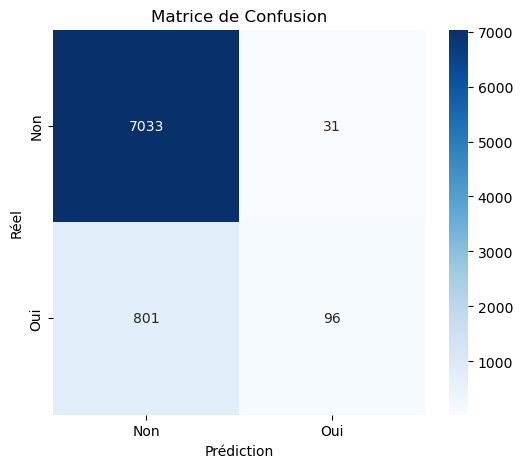


Configuration en cours :
- Métrique optimisée : precision
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Non

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Évaluation des métriques :
Précision : 0.2895
Rappel : 0.6778
F1 Score : 0.4057
F-beta Score (beta=1.0): 0.4057
Valeur nette (métrique métier) : -1774.5000


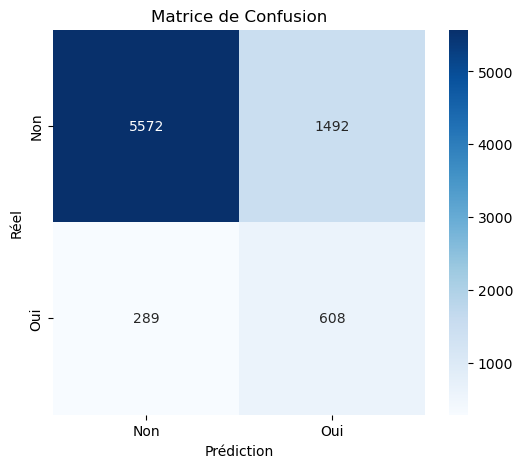


Configuration en cours :
- Métrique optimisée : precision
- SMOTE utilisé : Non
- Seuil optimal ajusté : Oui

Meilleurs paramètres : {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Meilleur seuil : 0.80, Meilleur precision Score : 1.0000

Évaluation des métriques :
Précision : 1.0000
Rappel : 0.0011
F1 Score : 0.0022
F-beta Score (beta=1.0): 0.0022
Valeur nette (métrique métier) : -447.0000


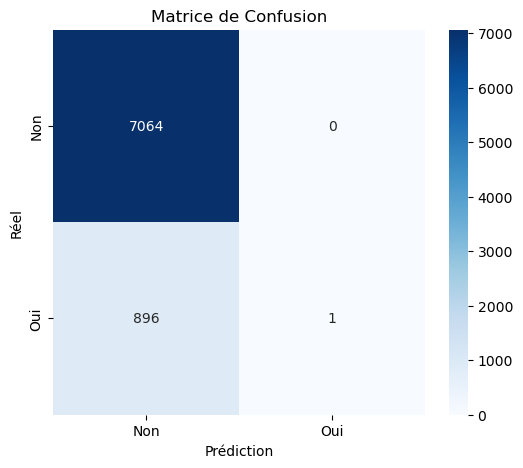


Configuration en cours :
- Métrique optimisée : precision
- SMOTE utilisé : Non
- Seuil optimal ajusté : Non

Meilleurs paramètres : {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

Évaluation des métriques :
Précision : 0.6980
Rappel : 0.1906
F1 Score : 0.2995
F-beta Score (beta=1.0): 0.2995
Valeur nette (métrique métier) : -303.0000


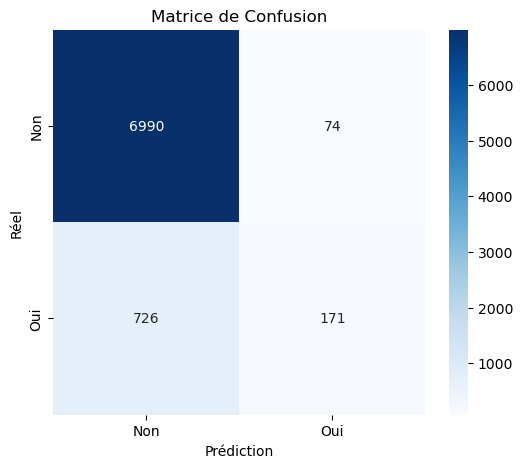


Configuration en cours :
- Métrique optimisée : f1
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Oui

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Meilleur seuil : 0.70, Meilleur f1 Score : 0.4800

Évaluation des métriques :
Précision : 0.4924
Rappel : 0.4682
F1 Score : 0.4800
F-beta Score (beta=1.0): 0.4800
Valeur nette (métrique métier) : -468.0000


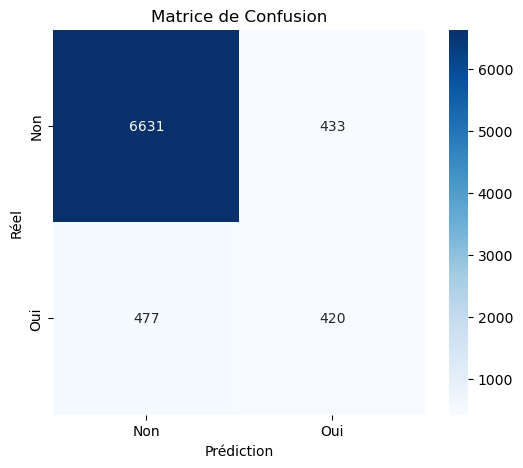


Configuration en cours :
- Métrique optimisée : f1
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Non

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

Évaluation des métriques :
Précision : 0.2887
Rappel : 0.6923
F1 Score : 0.4075
F-beta Score (beta=1.0): 0.4075
Valeur nette (métrique métier) : -1812.0000


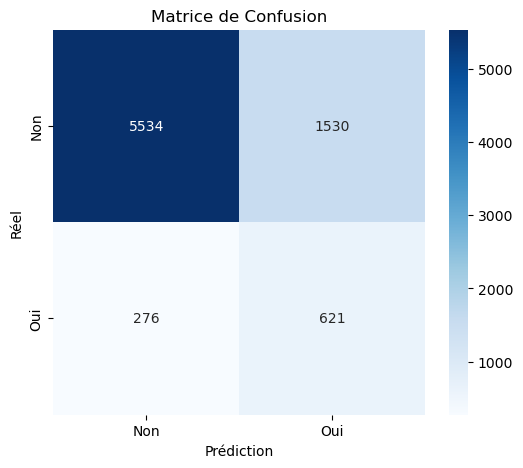


Configuration en cours :
- Métrique optimisée : f1
- SMOTE utilisé : Non
- Seuil optimal ajusté : Oui

Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur seuil : 0.20, Meilleur f1 Score : 0.4768

Évaluation des métriques :
Précision : 0.4321
Rappel : 0.5318
F1 Score : 0.4768
F-beta Score (beta=1.0): 0.4768
Valeur nette (métrique métier) : -673.5000


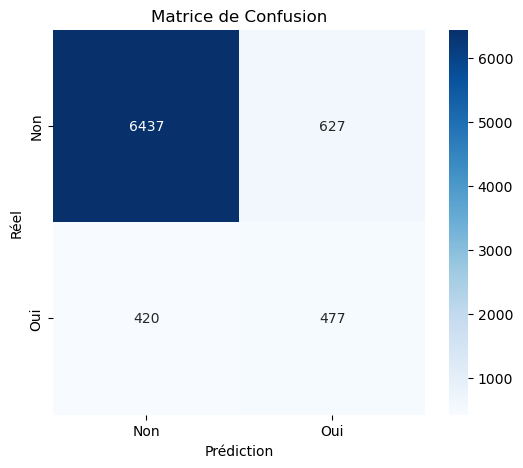


Configuration en cours :
- Métrique optimisée : f1
- SMOTE utilisé : Non
- Seuil optimal ajusté : Non

Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Évaluation des métriques :
Précision : 0.7034
Rappel : 0.2274
F1 Score : 0.3437
F-beta Score (beta=1.0): 0.3437
Valeur nette (métrique métier) : -271.5000


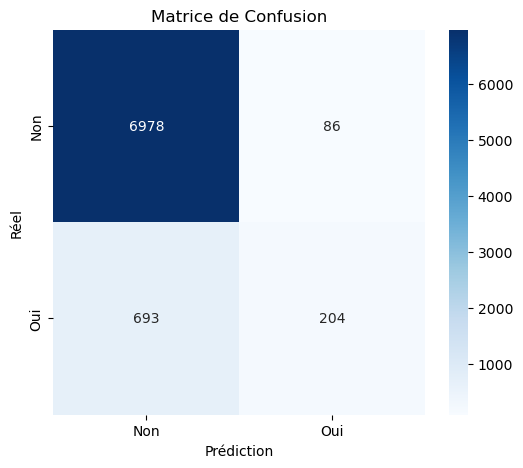


Configuration en cours :
- Métrique optimisée : fbeta
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Oui

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur seuil : 0.90, Meilleur fbeta Score : 0.5910

Évaluation des métriques :
Précision : 0.7068
Rappel : 0.2096
F1 Score : 0.3233
F-beta Score (beta=0.3): 0.5910
Valeur nette (métrique métier) : -283.5000


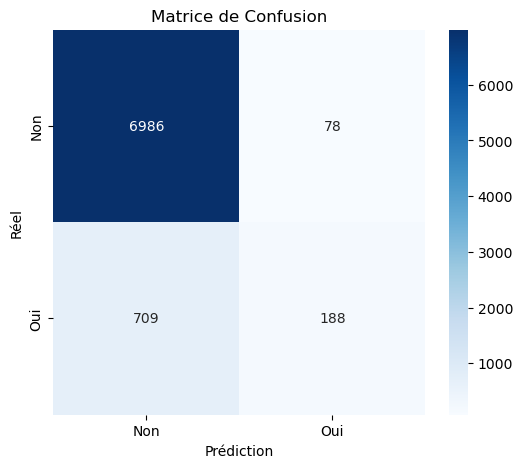


Configuration en cours :
- Métrique optimisée : fbeta
- SMOTE utilisé : Oui
- Seuil optimal ajusté : Non

SMOTE appliqué : Oversampling des données d'entraînement effectué.
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Évaluation des métriques :
Précision : 0.2895
Rappel : 0.6778
F1 Score : 0.4057
F-beta Score (beta=0.3): 0.3039
Valeur nette (métrique métier) : -1774.5000


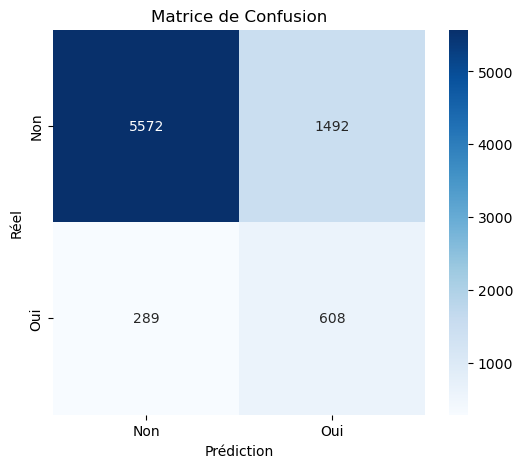


Configuration en cours :
- Métrique optimisée : fbeta
- SMOTE utilisé : Non
- Seuil optimal ajusté : Oui

Meilleurs paramètres : {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Meilleur seuil : 0.50, Meilleur fbeta Score : 0.6004

Évaluation des métriques :
Précision : 0.7063
Rappel : 0.2252
F1 Score : 0.3415
F-beta Score (beta=0.3): 0.6004
Valeur nette (métrique métier) : -271.5000


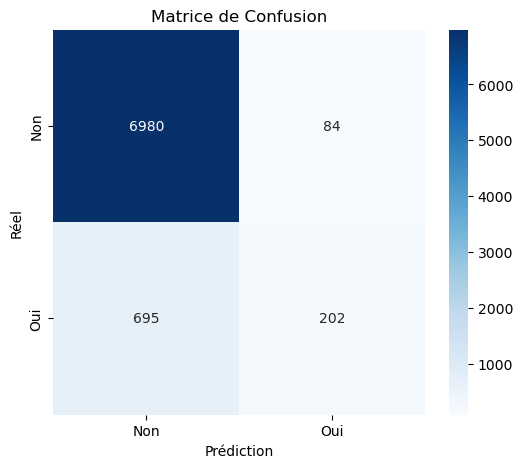


Configuration en cours :
- Métrique optimisée : fbeta
- SMOTE utilisé : Non
- Seuil optimal ajusté : Non

Meilleurs paramètres : {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Évaluation des métriques :
Précision : 0.7063
Rappel : 0.2252
F1 Score : 0.3415
F-beta Score (beta=0.3): 0.6004
Valeur nette (métrique métier) : -271.5000


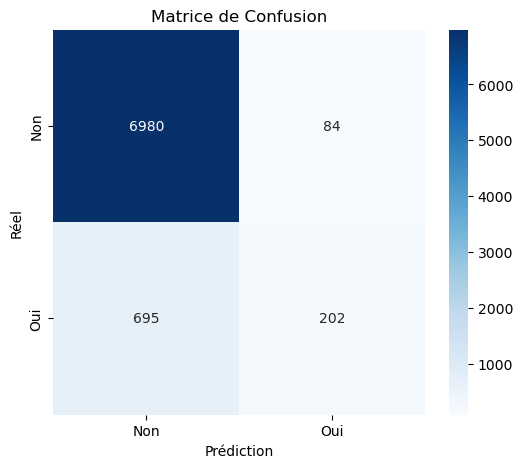

   Métrique Optimisée SMOTE Utilisé   Type de Seuil Utilisé  Seuil Optimal  \
0           precision           Oui           Seuil Optimal           0.95   
1           precision           Oui  Seuil Par Défaut (0.5)           0.50   
2           precision           Non           Seuil Optimal           0.80   
3           precision           Non  Seuil Par Défaut (0.5)           0.50   
4                  f1           Oui           Seuil Optimal           0.70   
5                  f1           Oui  Seuil Par Défaut (0.5)           0.50   
6                  f1           Non           Seuil Optimal           0.20   
7                  f1           Non  Seuil Par Défaut (0.5)           0.50   
8               fbeta           Oui           Seuil Optimal           0.90   
9               fbeta           Oui  Seuil Par Défaut (0.5)           0.50   
10              fbeta           Non  Seuil Par Défaut (0.5)           0.50   
11              fbeta           Non  Seuil Par Défaut (0.5)     

In [27]:
tab_recap=generate_results_table(X_train, y_train, X_test, y_test, param_grid)
print(tab_recap)